# Oblivious Amplitude Amplification

Here, we implement the "oblivious" version of Grover's algorithm. We suppose $|a\rangle$ and $|b\rangle$ are two kets in a possibly large Hilbert space $\mathcal{H}$. We are given access to the unitaries $e^{i\phi}|a\rangle\langle a|$, $e^{i\phi}|b\rangle\langle b|$ for arbitrary $\phi$, as well as a fixed unitary $U$ for which all we know is that $\langle a|U|b\rangle \neq 0$. The aim of the algorithm is to construct, using these resources, a unitary $Q$ such that $|\langle a|Q|b\rangle| \approx 1$.

For our purposes, we consider a system of six qubits where $|a\rangle$ is a superposition of all strings with random nonzero weights, and $|b\rangle$ is the particular string $|111111\rangle$.

In [55]:
'''Some generic python and jupyter imports'''
import numpy as np
from numpy import pi,sqrt

'''Qiskit imports'''
from qiskit import(
    QuantumCircuit
    , execute
    , Aer
    , ClassicalRegister
    , QuantumRegister
)
backend_svec = Aer.get_backend('statevector_simulator')
backend_qasm = Aer.get_backend('qasm_simulator')

'''Visualizations'''
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

### 1. State Preparation
First we begin by preparing our states. We are given that $|a\rangle$ is a superposition of all strings with random nonzero weights, and $|b\rangle$ is the particular string $|111111\rangle$.

|B0> Circuit:
     ┌───┐
q_0: ┤ X ├
     ├───┤
q_1: ┤ X ├
     ├───┤
q_2: ┤ X ├
     ├───┤
q_3: ┤ X ├
     ├───┤
q_4: ┤ X ├
     ├───┤
q_5: ┤ X ├
     └───┘

|A0> Circuit:
     ┌───┐┌────────────┐┌───────────┐┌────────────┐┌───────────┐ ┌───────────┐ »
q_0: ┤ H ├┤ P(0.39052) ├┤ P(1.2669) ├┤ P(0.70376) ├┤ P(6.2156) ├─┤ P(3.8434) ├─»
     ├───┤├────────────┤├───────────┤├────────────┤├───────────┤ ├───────────┤ »
q_1: ┤ H ├┤ P(0.39052) ├┤ P(1.2669) ├┤ P(0.70376) ├┤ P(6.2156) ├─┤ P(3.8434) ├─»
     ├───┤├────────────┤├───────────┤├────────────┤├───────────┤ ├───────────┤ »
q_2: ┤ H ├┤ P(0.39052) ├┤ P(1.2669) ├┤ P(0.70376) ├┤ P(6.2156) ├─┤ P(3.8434) ├─»
     ├───┤├────────────┤├───────────┤├────────────┤├───────────┤ └───┬───┬───┘ »
q_3: ┤ H ├┤ P(0.39052) ├┤ P(1.2669) ├┤ P(0.70376) ├┤ P(6.2156) ├─────┤ X ├─────»
     ├───┤├────────────┤├───────────┤└───┬───┬────┘├───────────┴┐    ├───┤     »
q_4: ┤ H ├┤ P(0.39052) ├┤ P(1.2669) ├────┤ X ├─────┤ P(0.70376) ├────┤ X ├─────»
     ├───┤├───────

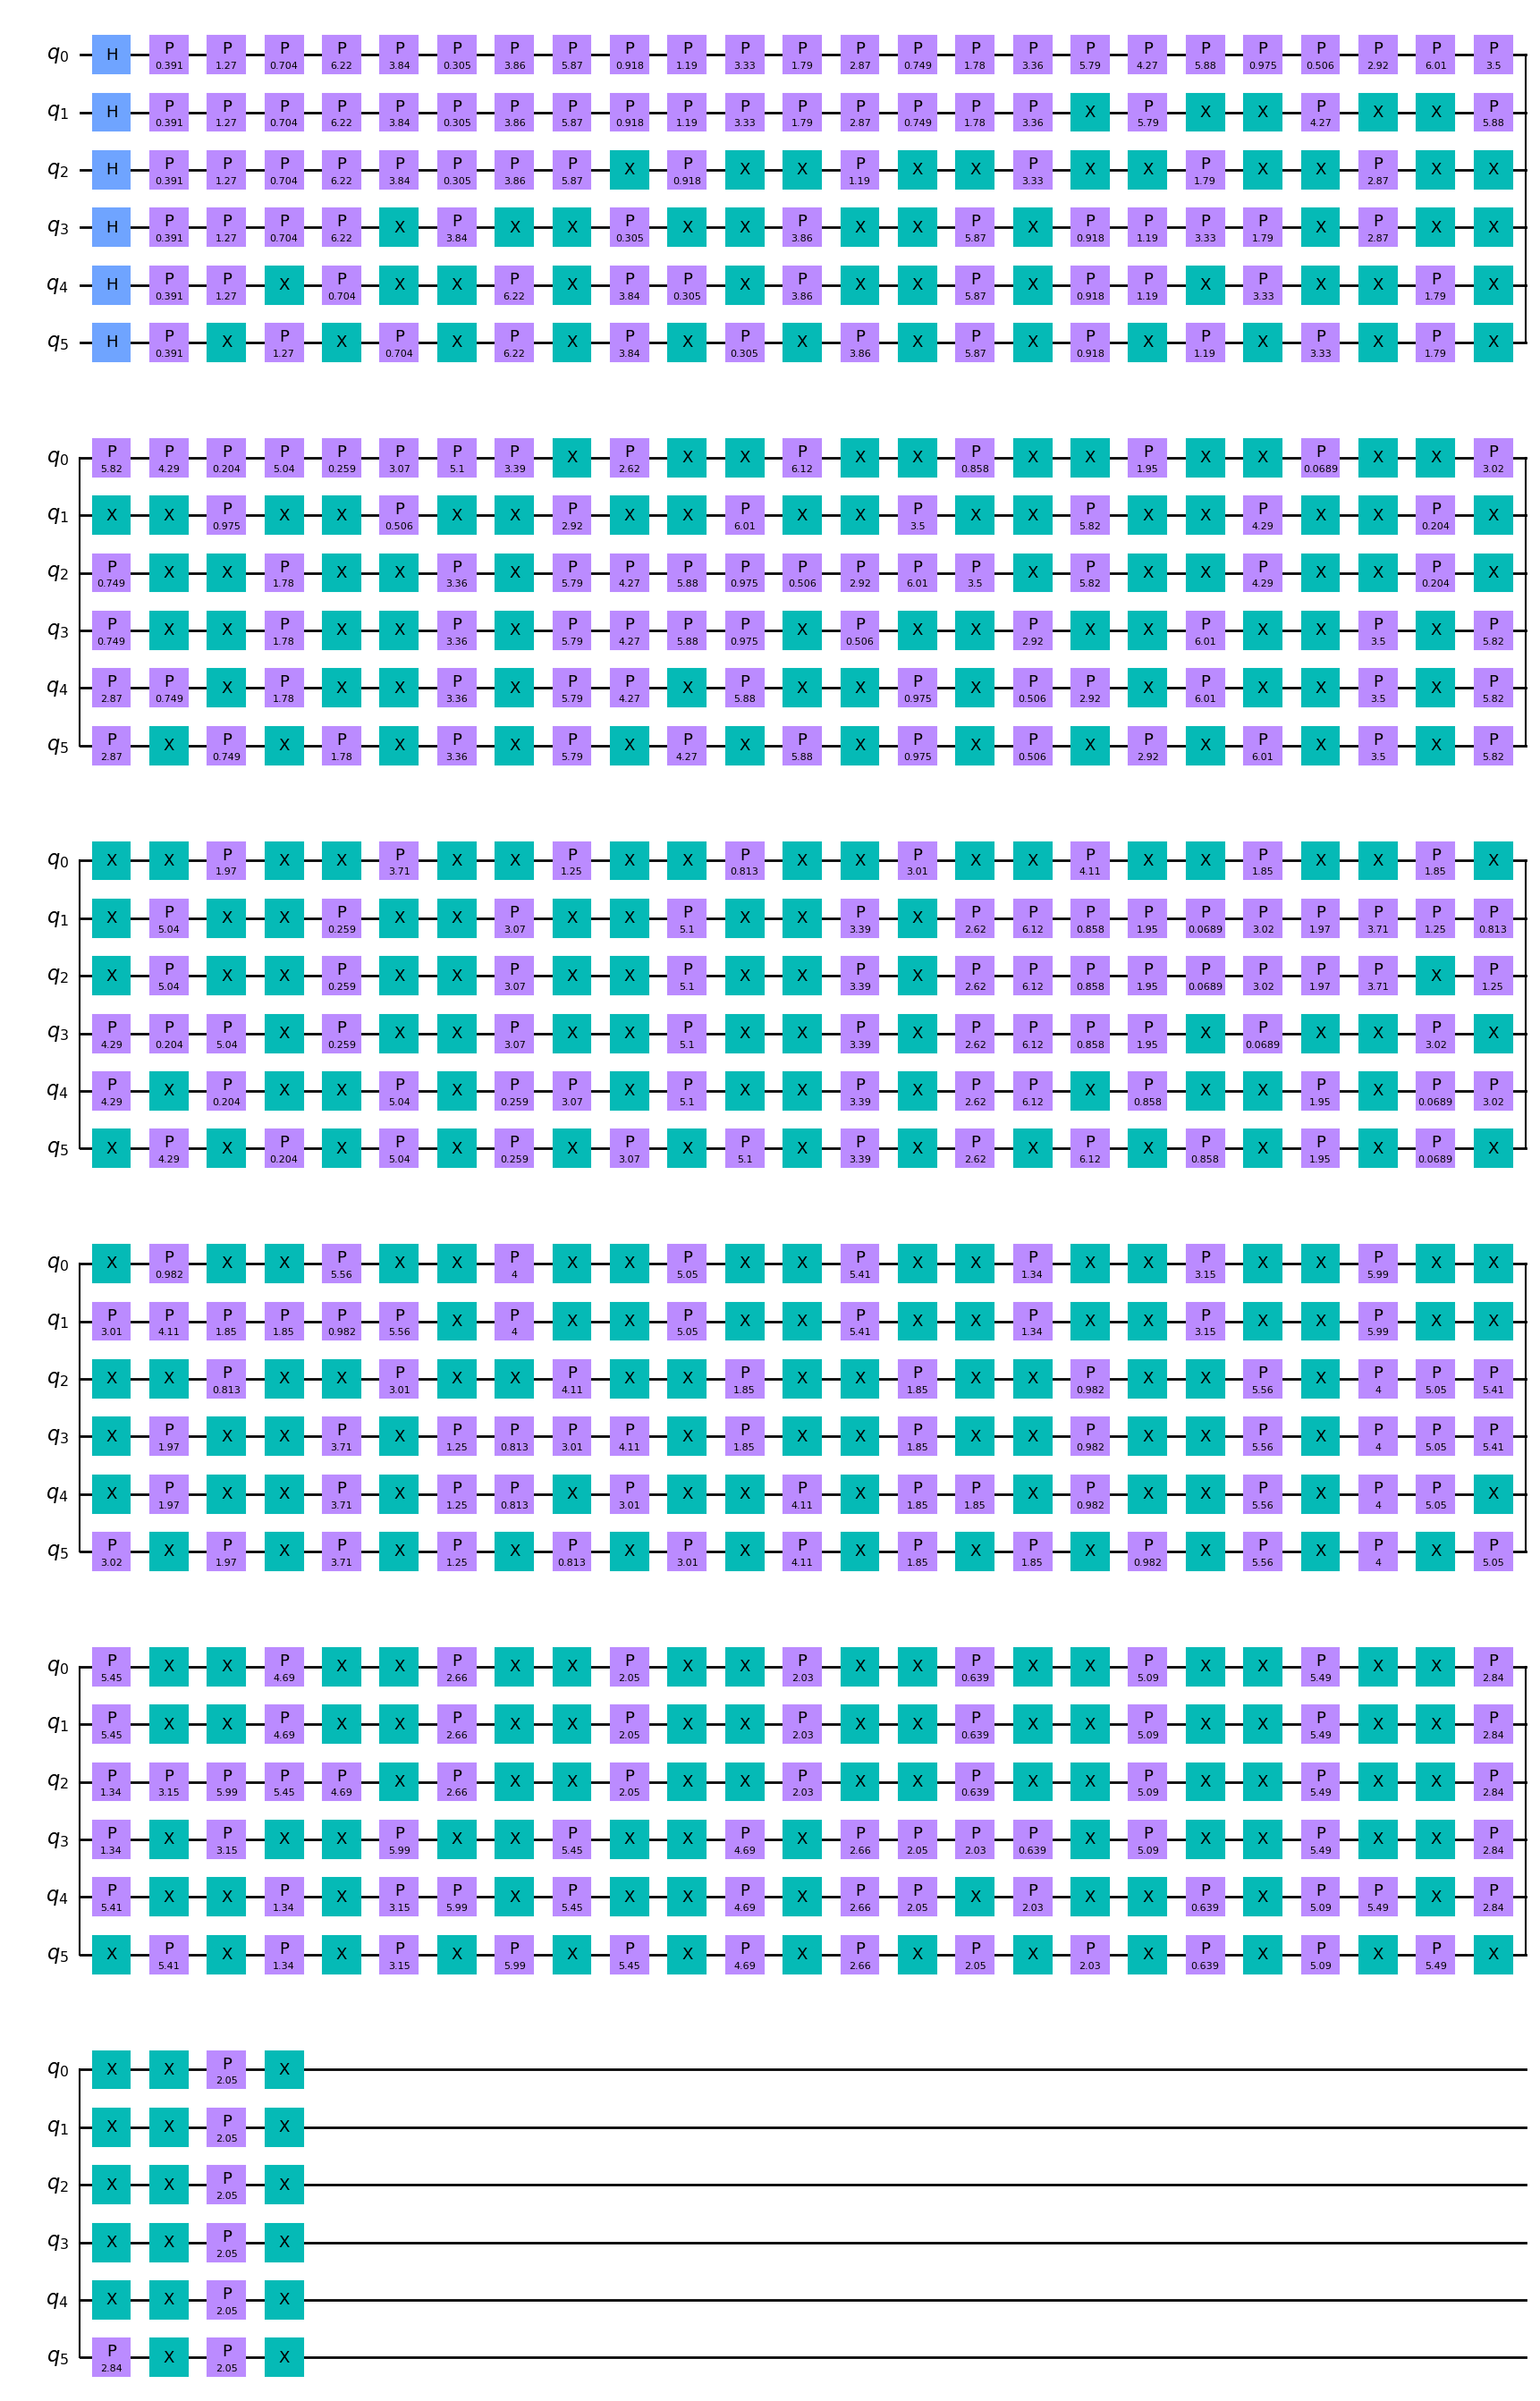

In [56]:
from qiskit import QuantumCircuit, Aer, execute
import numpy as np

# Define |B0> = |111111>
b0_circuit = QuantumCircuit(6, name='B0')
for qubit in range(6):
    b0_circuit.x(qubit)

# Define |A0>
a0_circuit = QuantumCircuit(6, name='A0')
for qubit in range(6): # Create equal superposition
    a0_circuit.h(qubit)

# Apply random phases
random_phases = np.random.rand(2**6)
for i, phase in enumerate(random_phases):
    binary_state = format(i, f'06b')  # Get binary
    for j, bit in enumerate(binary_state):
        if bit == '1':
            a0_circuit.x(j)  # Flip qubits
    a0_circuit.p(2 * np.pi * phase, range(6))  # Apply phase shift
    for j, bit in enumerate(binary_state):
        if bit == '1':
            a0_circuit.x(j)  # Undo flips

# Display circuits
print("|B0> Circuit:")
print(b0_circuit)

print("\n|A0> Circuit:")
print(a0_circuit)

# Toggle for visualization (a0 or b0)
a0_circuit.draw(output='mpl')


### 2. Define U
We now define U. Any U s.t. $\langle a|U|b\rangle \neq 0$ can work, we implement U as a rotation so $U = a(|A_0\rangle\langle B_0| - |A_\perp\rangle\langle B_\perp|)  + \sqrt{1 - a^2}(|A_\perp\rangle\langle B_0| + |A_0\rangle\langle B_\perp|)$.

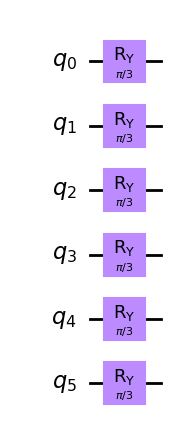

In [57]:
def define_U(a, a0_circuit, b0_circuit):
    # Create U circuit
    u_circuit = QuantumCircuit(6, name='U')

    # Define theta = 2 * sin^(-1)(a)
    theta = 2 * np.arcsin(a)

    # Rotations
    for qubit in range(6):
        u_circuit.ry(theta, qubit)  # Apply the rotation around Y axis

    return u_circuit

U_circuit = define_U(0.5, a0_circuit, b0_circuit)
U_circuit.draw('mpl')


### 3. Find Reflection Operators
We define our phase/reflection operators as $A_\phi = e^{i\phi|A_0\rangle\langle A_0|}$, $B_\phi = e^{i\phi|B_0\rangle\langle B_0|}$.

In [58]:
# Define A_phi and B_phi operators
def define_phase_operator(phi, target_circuit):
    """
    A_phi = exp(i * phi * |A0><A0|)
    B_phi = exp(i * phi * |B0><B0|)
    """
    phase_circuit = QuantumCircuit(6, name=f'Phase_{phi}')

    # Apply controlled phase rotations based on the target circuit
    phase_circuit.compose(target_circuit, inplace=True)
    for qubit in range(6):
        phase_circuit.p(phi, qubit)  # Apply phase shift
    phase_circuit.compose(target_circuit.inverse(), inplace=True)

    return phase_circuit

# Example usage of A_phi and B_phi
phi = np.pi
A_phi_circuit = define_phase_operator(phi, a0_circuit)
B_phi_circuit = define_phase_operator(phi, b0_circuit)

print("\nA_phi Circuit:")
print(A_phi_circuit)

print("\nB_phi Circuit:")
print(B_phi_circuit)



A_phi Circuit:
     ┌───┐┌────────────┐┌───────────┐┌────────────┐┌───────────┐ ┌───────────┐ »
q_0: ┤ H ├┤ P(0.39052) ├┤ P(1.2669) ├┤ P(0.70376) ├┤ P(6.2156) ├─┤ P(3.8434) ├─»
     ├───┤├────────────┤├───────────┤├────────────┤├───────────┤ ├───────────┤ »
q_1: ┤ H ├┤ P(0.39052) ├┤ P(1.2669) ├┤ P(0.70376) ├┤ P(6.2156) ├─┤ P(3.8434) ├─»
     ├───┤├────────────┤├───────────┤├────────────┤├───────────┤ ├───────────┤ »
q_2: ┤ H ├┤ P(0.39052) ├┤ P(1.2669) ├┤ P(0.70376) ├┤ P(6.2156) ├─┤ P(3.8434) ├─»
     ├───┤├────────────┤├───────────┤├────────────┤├───────────┤ └───┬───┬───┘ »
q_3: ┤ H ├┤ P(0.39052) ├┤ P(1.2669) ├┤ P(0.70376) ├┤ P(6.2156) ├─────┤ X ├─────»
     ├───┤├────────────┤├───────────┤└───┬───┬────┘├───────────┴┐    ├───┤     »
q_4: ┤ H ├┤ P(0.39052) ├┤ P(1.2669) ├────┤ X ├─────┤ P(0.70376) ├────┤ X ├─────»
     ├───┤├────────────┤└───┬───┬───┘┌───┴───┴───┐ └───┬───┬────┘┌───┴───┴────┐»
q_5: ┤ H ├┤ P(0.39052) ├────┤ X ├────┤ P(1.2669) ├─────┤ X ├─────┤ P(0.70376) ├»
     └───┘└─

### 4. Putting it Together
We use the unitaries and reflection operators to create a circuit for $Q$.

$UB_{\phi}U^{\dagger} = e^{i\pi H^{\otimes n}|0\rangle\langle 0|H^{\otimes n}} = I - 2| \psi_0 \rangle \langle \psi_0 |$

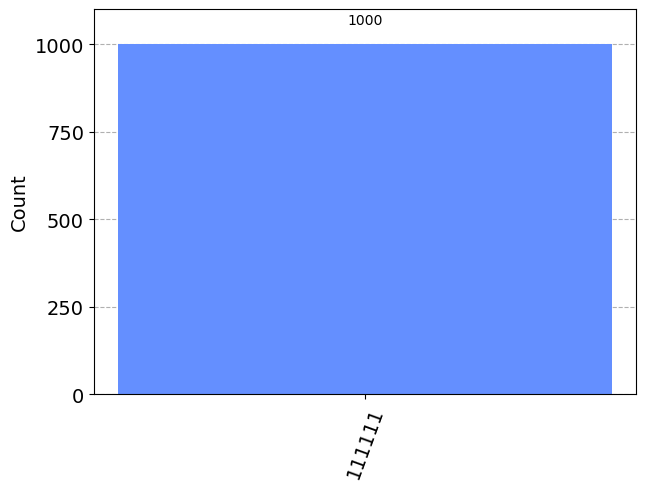

In [63]:

# Define a function to run the simulation
def simulate_circuit(circuit, repetitions=1000):
    """
    Simulate the given circuit with a specified number of repetitions.
    """
    # Use the Aer simulator
    simulator = Aer.get_backend('qasm_simulator')
    
    # Add measurements to all qubits
    measured_circuit = circuit.copy()
    measured_circuit.measure_all()
    
    # Execute the circuit
    result = execute(measured_circuit, simulator, shots=repetitions).result()
    counts = result.get_counts()
    
    return counts

# Modify the algorithm to include A_phi repeatedly
def iterate_algorithm(U_circuit, B_phi_circuit, A_phi_circuit, iterations):
    """
    Apply the algorithm circuit repeatedly, incorporating A_phi.
    """
    iterative_circuit = QuantumCircuit(6, name='Iterative_Algorithm')
    
    # Initialize with A_phi
    iterative_circuit.compose(A_phi_circuit, inplace=True)
    
    # Apply the algorithm repeatedly
    for _ in range(iterations):
        iterative_circuit.compose(U_circuit.inverse(), inplace=True)
        iterative_circuit.compose(B_phi_circuit, inplace=True)
        iterative_circuit.compose(U_circuit, inplace=True)
    return iterative_circuit

# Set up the simulation
iterations = 2
iterative_circuit = iterate_algorithm(U_circuit, B_phi_circuit, A_phi_circuit, iterations)

# Simulate the iterative circuit
counts = simulate_circuit(iterative_circuit)

# Plot the results
plot_histogram(counts)